In [1]:
from ns_fit_waveform import *

/opt/homebrew/Caskroom/miniforge/base/envs/ppmhm/lib/python3.10/site-packages/prim/taylort3.py:20: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import GAMMA, MTSUN_SI


In [2]:
!ls /Users/sebastian.khan/personal/data/ppmHM_2024_11_05__ns_data_sample

SXS_BBH_0185-Lev3__SEOBNRv5HM.h5 SXS_BBH_2497-Lev3__SEOBNRv5HM.h5
SXS_BBH_2487-Lev5__SEOBNRv5HM.h5 SXS_BBH_3864-Lev6__SEOBNRv5HM.h5
SXS_BBH_2496-Lev3__SEOBNRv5HM.h5 metadata.csv


In [3]:
!head /Users/sebastian.khan/personal/data/ppmHM_2024_11_05__ns_data_sample/metadata.csv

approximant,chi1z,chi2z,is_reference,modes,q,sxs_sim_name,filepath,hybrid_name,q_rounded,chi1z_rounded,chi2z_rounded,chi_eff,chi_eff_rounded,ID
SEOBNRv5HM,-0.400075117643,-0.799055770955,True,"[[2 2]
 [2 1]
 [3 3]
 [3 2]
 [4 4]
 [4 3]
 [5 5]
 [5 4]]",5.9976896469405085,SXS:BBH:2212/Lev3,/scratch/sebastian.khan/data/ppmHM_2024_11_11/SXS_BBH_2212-Lev3__SEOBNRv5HM.h5,SXS_BBH_2212-Lev3__SEOBNRv5HM,5.998,-0.4,-0.799,-0.45709117200409044,-0.4571,0
SEOBNRv5HM,0.390150308681,-0.479875258678,False,"[[2 2]


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import prim.taylort3
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
import scienceplots
plt.style.use(['science', 'light', 'notebook'])

In [5]:
t=np.linspace(-1000, -100, 100)
tc=0
eta=0.25
M=1
chi1=0
chi2=0
phi_0=0
t3phi = prim.taylort3.TaylorT3_Orbital_Phase(t, tc, eta, M, chi1, chi2, phi_0)

t3omega = prim.taylort3.TaylorT3_Omega_GW(t, tc, eta, M, chi1, chi2)

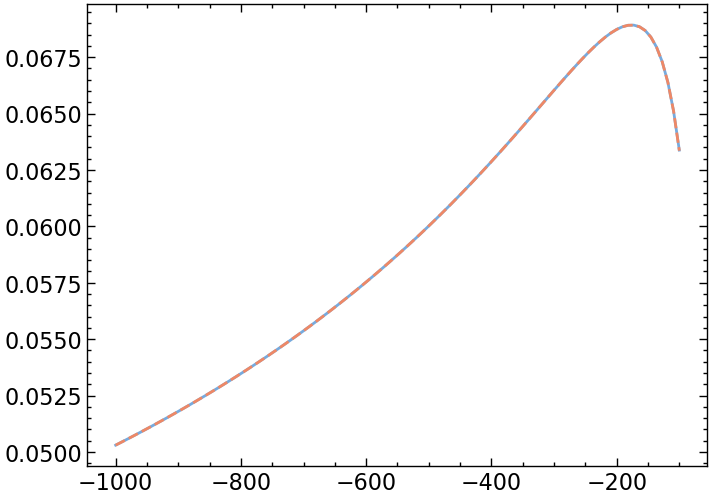

In [6]:
# plt.plot(t, t3phi)
plt.plot(t, IUS(t, 2*t3phi).derivative()(t))
plt.plot(t, t3omega, ls='--')

In [7]:
wf_index = 0
root_dir = pathlib.Path(
    "/Users/sebastian.khan/personal/data/ppmHM_2024_11_05__ns_data_sample"
)

metadata = get_ns_metadata(root_dir)

# print(metadata)

metadata = metadata.iloc[wf_index]

print("waveform to model")
print(metadata)

q = metadata["q"]
chi1z = metadata["chi1z"]
chi2z = metadata["chi2z"]
modes = metadata["modes"]
hybrid_name = metadata["hybrid_name"]
eta = phenom.eta_from_q(q)

hyb_wf = load_hybrid_h5_file(metadata["filepath"])

waveform to model
approximant                                               SEOBNRv5HM
chi1z                                                       0.000001
chi2z                                                       0.000001
is_reference                                                   False
modes                               [(2, 2), (3, 2), (4, 4), (5, 4)]
q                                                                1.0
sxs_sim_name                                       SXS:BBH:2496/Lev3
hybrid_name                            SXS_BBH_2496-Lev3__SEOBNRv5HM
q_rounded                                                        1.0
chi1z_rounded                                                    0.0
chi2z_rounded                                                    0.0
chi_eff                                                     0.000001
chi_eff_rounded                                                  0.0
ID                                                               157
filename        

In [8]:
hyb_wf.compute_amplitude().compute_phase().compute_frequency()

In [9]:
plt.plot(hyb_wf.times, hyb_wf.phases[2,2])

In [10]:
ts = hyb_wf.times[hyb_wf.times < -100]

In [11]:
t3phi = -2*prim.taylort3.TaylorT3_Orbital_Phase(ts, tc, eta, M, chi1, chi2, phi_0)

In [12]:
t3omega = -prim.taylort3.TaylorT3_Omega_GW(ts, tc, eta, M, chi1, chi2)

In [13]:
plt.plot(hyb_wf.times, hyb_wf.phases[2,2])
plt.plot(ts, t3phi-t3phi[0])

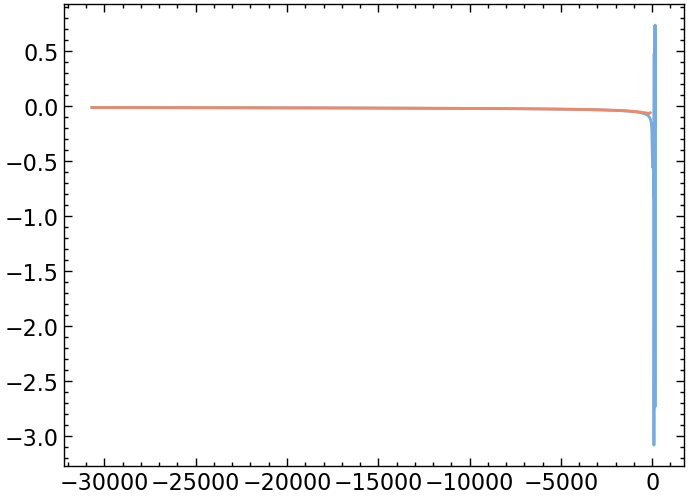

In [14]:
plt.plot(hyb_wf.times, hyb_wf.frequencies[2,2])
plt.plot(ts, t3omega)

In [15]:
phi_newt = prim.taylort3.TaylorT3_Orbital_Phase_Newt(ts, 0,  eta, 1)

In [16]:
plt.plot(hyb_wf.times, hyb_wf.phases[2,2])
plt.plot(ts, t3phi-t3phi[0])


plt.plot(ts, -2*(phi_newt-phi_newt[0]))

In [30]:
hyb_wf.phases[2,2][0]

-0.0038894757081875554

In [31]:
hyb_wf.phases[4,4][0]

0.009757416726464319

In [157]:
def phase_ansatz(a8, a9, a10, a11, t, eta, tc=0, M=1):
    theta = prim.taylort3.TaylorT3_theta(t, tc, eta, M)
    y = a8*theta**8 + a9*theta**9 + a10*theta**10 + a11*theta**11
    return -y

In [175]:
def plot_phase(hyb_wf, eta, t_start, t_end, M=1):
    """have to be careful about relative phases for higher modes"""
    times_nr = hyb_wf.times
    phi_nr_22 = hyb_wf.phases[2,2]
    phi_nr_44 = hyb_wf.phases[4,4]
    phi_nr_orb = phi_nr_22/2
    
    mask = (times_nr >= t_start) & (times_nr <= t_end)
    x = times_nr[mask]
    y = phi_nr_orb[mask]
    y_phi_orb_0 = y[0]
    y = y-y_phi_orb_0
    
    t3N = prim.taylort3.TaylorT3_Orbital_Phase_Newt(x, 0, eta, M)
    t3N = t3N - t3N[0]
    t3N = -t3N
    # t3N = -2*t3N

    # yres = y - t3N
    # plt.plot(x, yres)

    phi_nr_22 = phi_nr_22 - 2*y_phi_orb_0
    yres = phi_nr_22[mask] - 2*t3N
    # yres = yres/(2*t3N)
    plt.plot(x, yres)

    from scipy.optimize import curve_fit
    func = lambda x, a, b, c, d : phase_ansatz(a, b, c, d, x, eta)*(2*t3N)
    popt, pcov = curve_fit(func, x, yres)
    print(popt)
    plt.plot(x, func(x, *popt), ls='--')
    
    # phi_nr_44 = phi_nr_44 - 4*y_phi_orb_0
    # yres = phi_nr_44[mask] - 4*t3N
    # plt.plot(x, yres)

    # plt.xlim(-15000, -10000)
    # plt.ylim(0, 0.2)

[ 145.45652739 -624.45177672  914.68443424 -455.14561202]


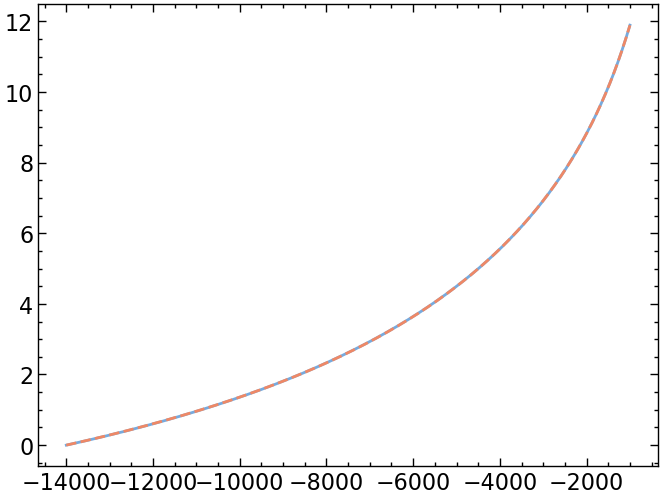

In [176]:
plot_phase(hyb_wf, eta, -14000, -1000)